- This notebook contains experiments for the MovieLens (1M) Dataset for the following models:

- **Updated PSI**

- **Regular PSI**

- **Pure SVD**

- **Most Pop**

- **Rand Rec**

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "8"        # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=478
os.environ["NUMEXPR_NUM_THREADS"] = "8"

In [ ]:
#import os; os.environ["MKL_NUM_THREADS"] = "1" # as required by implicit

## Imports

In [ ]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn

## Functions

In [ ]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')
#sys.path.append('/content/')

In [ ]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [ ]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE, auc_score,TrainTest
from b_AlgoFunctions import mean_auc,tune_ALS,nonzeros,least_squares_cg,alternating_least_squares_cg
from b_AlgoFunctions import HitrEval_noprint,SVDoptimalSearch

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR, MRR_Eval,getAll_MRR_Eval
from c_PredEval import TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR, ials_TopNPred,ials_getALLPred
from c_PredEval import ials_getALLPredTQDM,ials_ALLUSERSpred,ialsALLPred_ALLUSERS,TQDM_ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat

In [ ]:
def SingleStepRatMat_2(DF,V,user_column,item_column):  ##rows_ = n_users,cols_ = n_items
    rows_ = DF[user_column].max()+1 
    cols_ = V.shape[0] 
    
    rows0 = DF[user_column].values
    cols0 = DF[item_column].values
    data  = np.broadcast_to(1., DF.shape[0]) # ignore ratings

    A0_Rating_matrix = coo_matrix((data, (rows0, cols0)), shape=(rows_, cols_)).tocsr()
    if A0_Rating_matrix.nnz < len(data):
        A0_Rating_matrix = A0_Rating_matrix._with_data(np.broadcast_to(1., A0_Rating_matrix.nnz), copy=False)

    return A0_Rating_matrix

def AllSingleStepRatMat_2(DFList,Vlist,user_column,item_column):
    Rating_matrix_list = []
    for df,v in zip(DFList,Vlist):
        df_Mat = SingleStepRatMat_2(df,v,user_column,item_column)
        Rating_matrix_list.append(df_Mat)
    return Rating_matrix_list              


## Apply Functions on *MovieLenDF*

#Data  Preparation

In [ ]:
ML1M_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/newIncreMLDF_1M.zip') 
ML1M_DF['timestamp'] = pd.to_datetime(ML1M_DF['timestamp']) 
print(ML1M_DF.shape)   #userId_int
print(ML1M_DF.dtypes)
ML1M_DF

(575281, 7)
userId_int               int64
movieId_int              int64
rating                   int64
timestamp       datetime64[ns]
userId                   int64
productId                int64
timestamp_YM            object
dtype: object


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04
...,...,...,...,...,...,...,...
575276,4958,2453,1,2003-02-28 17:44:20,1081,1838,2003-02
575277,4958,3489,1,2003-02-28 17:45:20,1081,632,2003-02
575278,4958,1407,1,2003-02-28 17:47:23,1081,677,2003-02
575279,4958,3264,1,2003-02-28 17:49:08,1081,1018,2003-02


In [ ]:
print(ML1M_DF.shape)
print("For users: ")
print(ML1M_DF['userId'].nunique())
print(ML1M_DF['userId'].max())
print()
print("For items: ")
print(ML1M_DF['productId'].nunique())
print(ML1M_DF['productId'].max())
print()
print("Timestamp")
print(ML1M_DF['timestamp'].min())
print(ML1M_DF['timestamp'].max())

(575281, 7)
For users: 
6038
6037

For items: 
3533
3532

Timestamp
2000-04-25 23:05:32
2003-02-28 17:49:50


**Data Split**

In [ ]:
print("Size of Dataset: ", ML1M_DF.shape)
print('Min Date: ', ML1M_DF['timestamp'].min())
print("Max Date: ",ML1M_DF['timestamp'].max())

Size of Dataset:  (575281, 7)
Min Date:  2000-04-25 23:05:32
Max Date:  2003-02-28 17:49:50


In [ ]:
train_df = ML1M_DF[ML1M_DF['timestamp_YM'] < '2000-12']    #'2016-02
print("DF Shape: ",train_df['userId'].shape)  ##63%
print("NUsers  : ",train_df['userId'].nunique())

DF Shape:  (458067,)
NUsers  :  5361


In [ ]:
remainder_df = ML1M_DF[ML1M_DF['timestamp_YM'] >= '2000-12']  
print(remainder_df['userId'].nunique())
print(remainder_df.shape)

1801
(117214, 7)


In [ ]:
n = 8500  #num_of_interaction/no_steps
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    print(df['userId'].nunique())
print()
print(g+1)    

213
197
148
194
233
255
286
309
468
526
517
470
453
362

14


**Traintest Split**

In [ ]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  2000-04-25 23:05:32
End Time:    2000-11-30 23:59:47

Num of interactions:  458067
Num of uniqueUsers:   5361


In [ ]:
ΔA_train = all_df[:4] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())



Incremental Train steps:  4
Start Time:  2000-12-01 00:00:15
End Time:    2000-12-10 04:09:37


In [ ]:
ΔA_test = all_df[4:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  10
Start Time:  2000-12-10 04:09:37
End Time:    2003-02-28 17:49:50


In [ ]:
ΔA_test[0]['timestamp'].max()

Timestamp('2000-12-14 00:34:30')

In [ ]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(ML1M_DF,'userId','timestamp',ΔA_test)
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

2000-04-25 23:05:32
2000-12-19 13:44:29

2000-12-14 00:36:17
2000-12-19 13:44:29


In [ ]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

5787 5788
5869 5870
5973 5974
6029 6030
6029 6030
6030 6031
6032 6033
6034 6035
6035 6036
6037 6038


In [ ]:
print(ΔA_test[2].shape)
print(PSITest_list[2].shape)
print(HOLDOUT_list[2]['userId'].nunique())

(8500, 7)
(8214, 7)
286


**Find new users and items**

In [ ]:
Tstps = ML1M_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = ML1M_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2000-12-10 04:09:37
2000-04-25 23:05:32
2000-12-10 04:09:37

2000-04-25 23:05:32
2000-12-14 00:34:30


In [ ]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=10)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[5711 5712 5713 5714 5715 5716 5717 5718 5719 5720]

[3478 3479 3480 3481 3482 3483]


In [ ]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
77 6

82 5

104 0

56 6

0 5

1 5

2 7

2 9

1 9

2 3



**Rank Tuning**

In [ ]:
########## #####
#Rank Tuning 
######### ######

In [ ]:
#MOVIElen_1M
newMLDF_1M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_afterUpdt.csv.zip')
newMLDF_1M['timestamp'] = pd.to_datetime(newMLDF_1M['timestamp']) 
print(newMLDF_1M.shape)   #userId_int
newMLDF_1M.head()

(575281, 9)


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04,0,0
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04,0,1
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04,0,2
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04,0,3
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04,0,4


In [ ]:

import pickle
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)  

In [ ]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [ ]:
AllHitr_,maxhit,maxrank = SVDoptimalSearch(SVD_UserItemMAT[0],newHoldout_list[0],'Updated_UserID','Updated_ItemID',start=10,end=200,increment=10,N=10)

 10%|█         | 2/20 [00:00<00:03,  5.88it/s]
 Max Rank: 10 | HitRate:0.06437768240343347

 Max Rank: 20 | HitRate:0.07296137339055794
100%|██████████| 20/20 [00:15<00:00,  1.30it/s]
 Best-Params; Max Rank: 20 | HitRate: 0.07296137339055794



In [ ]:
print(maxhit,maxrank )
rank_list = list(range(10,201,10))
print(rank_list)

0.07296137339055794 20
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


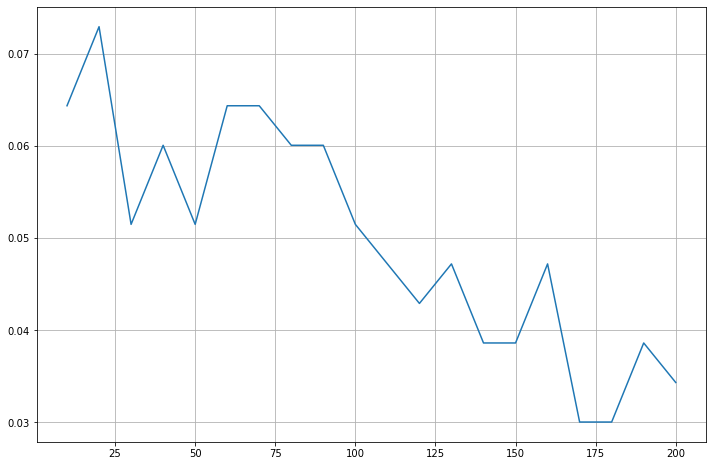

In [ ]:
plt.figure(figsize=(12,8))  
plt.plot(rank_list,AllHitr_)   ###Max == 100
plt.grid()

# Updated PSI

**Get Updt RatMat**

In [ ]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(458067, 7)


<5711x3478 sparse matrix of type '<class 'numpy.float64'>'
	with 458067 stored elements in Compressed Sparse Row format>

In [ ]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <5711x3478 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>]

**Allsteps Update**

In [ ]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=20)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 4/4 [00:00<00:00, 165.83it/s]
U_start shape:  (5711, 20)
S_start shape:  (20, 20)
V_start shape:  (3478, 20)



In [ ]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [ ]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,AllDF_list,New_itemsList,New_usersList,U_list,
                                       S_list,V_list,'userId','productId',Nsteps=10,k=20,Forced_Orth=False)

100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


**Output Check**

In [ ]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

3477
5710


In [ ]:
print(len(In_DomainITEMS[3477+1:]))
print(In_DomainITEMS[3477+1:][:10])
print()
print(len(In_DomainUSERS[5710+1:]))
print(In_DomainUSERS[5710+1:][:10])

55
[3478, 3479, 3480, 3481, 3482, 3483, 3484, 3487, 3485, 3486]

327
[5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720]


In [ ]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

0
[]

0
[]


In [ ]:
for x in list(itemID_dict)[3477+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 3478, UpdtId: 3478 
Id: 3479, UpdtId: 3479 
Id: 3480, UpdtId: 3480 
Id: 3481, UpdtId: 3481 
Id: 3482, UpdtId: 3482 
Id: 3483, UpdtId: 3483 
Id: 3484, UpdtId: 3484 
Id: 3487, UpdtId: 3485 
Id: 3485, UpdtId: 3486 
Id: 3486, UpdtId: 3487 
Id: 3488, UpdtId: 3488 
Id: 3491, UpdtId: 3489 
Id: 3492, UpdtId: 3490 
Id: 3493, UpdtId: 3491 
Id: 3494, UpdtId: 3492 
Id: 3489, UpdtId: 3493 
Id: 3490, UpdtId: 3494 
Id: 3495, UpdtId: 3495 
Id: 3496, UpdtId: 3496 
Id: 3497, UpdtId: 3497 
Id: 3498, UpdtId: 3498 
Id: 3499, UpdtId: 3499 
Id: 3500, UpdtId: 3500 
Id: 3501, UpdtId: 3501 
Id: 3502, UpdtId: 3502 
Id: 3503, UpdtId: 3503 
Id: 3504, UpdtId: 3504 
Id: 3505, UpdtId: 3505 
Id: 3506, UpdtId: 3506 
Id: 3507, UpdtId: 3507 
Id: 3508, UpdtId: 3508 
Id: 3509, UpdtId: 3509 
Id: 3510, UpdtId: 3510 
Id: 3511, UpdtId: 3511 
Id: 3512, UpdtId: 3512 
Id: 3513, UpdtId: 3513 
Id: 3514, UpdtId: 3514 
Id: 3515, UpdtId: 3515 
Id: 3516, UpdtId: 3516 
Id: 3517, UpdtId: 3517 
Id: 3518, UpdtId: 3518 
Id: 3519, UpdtId

In [ ]:
for x in list(userID_dict)[5710:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 5710, UpdtId: 5710 
Id: 5711, UpdtId: 5711 
Id: 5712, UpdtId: 5712 
Id: 5713, UpdtId: 5713 
Id: 5714, UpdtId: 5714 
Id: 5715, UpdtId: 5715 
Id: 5716, UpdtId: 5716 
Id: 5717, UpdtId: 5717 
Id: 5718, UpdtId: 5718 
Id: 5719, UpdtId: 5719 
Id: 5720, UpdtId: 5720 
Id: 5721, UpdtId: 5721 
Id: 5722, UpdtId: 5722 
Id: 5723, UpdtId: 5723 
Id: 5724, UpdtId: 5724 
Id: 5725, UpdtId: 5725 
Id: 5726, UpdtId: 5726 
Id: 5727, UpdtId: 5727 
Id: 5728, UpdtId: 5728 
Id: 5729, UpdtId: 5729 
Id: 5730, UpdtId: 5730 
Id: 5731, UpdtId: 5731 
Id: 5732, UpdtId: 5732 
Id: 5733, UpdtId: 5733 
Id: 5734, UpdtId: 5734 
Id: 5735, UpdtId: 5735 
Id: 5736, UpdtId: 5736 
Id: 5737, UpdtId: 5737 
Id: 5738, UpdtId: 5738 
Id: 5739, UpdtId: 5739 
Id: 5740, UpdtId: 5740 
Id: 5741, UpdtId: 5741 
Id: 5742, UpdtId: 5742 
Id: 5743, UpdtId: 5743 
Id: 5744, UpdtId: 5744 
Id: 5745, UpdtId: 5745 
Id: 5746, UpdtId: 5746 
Id: 5747, UpdtId: 5747 
Id: 5748, UpdtId: 5748 
Id: 5749, UpdtId: 5749 
Id: 5750, UpdtId: 5750 
Id: 5751, UpdtId

In [ ]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

11 11
(5711, 20) (3478, 20)

(5788, 20) (3484, 20)
(5870, 20) (3489, 20)
(5974, 20) (3489, 20)
(6030, 20) (3495, 20)
(6030, 20) (3500, 20)
(6031, 20) (3505, 20)
(6033, 20) (3512, 20)
(6035, 20) (3521, 20)
(6036, 20) (3530, 20)
(6038, 20) (3533, 20)


In [ ]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

5788 3484
5870 3489
5974 3489
6030 3495
6030 3500
6031 3505
6033 3512
6035 3521
6036 3530
6038 3533


In [ ]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(ML1M_DF['userId'].nunique(),ML1M_DF['productId'].nunique())

6038 3533
6038 3533


Data Adjustments

**Data Adjustment**

In [ ]:
len(AllUpdtITEMS_)

10

In [ ]:
newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

10it [00:00, 118.81it/s]10

233 233
255 255
286 286
309 309
468 468
526 526
517 517
470 470
453 453
362 362



In [ ]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

10it [00:06,  1.49it/s]
5787 3483
5869 3488
5973 3488
6029 3494
6029 3498
6030 3504
6032 3509
6034 3520
6035 3529
6037 3531



In [ ]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

10it [00:00, 49.88it/s]8267 8267
8245 8245
8214 8214
8191 8191
8032 8032
7974 7974
7983 7983
8030 8030
8047 8047
6352 6352



In [ ]:
newMLDF_1M = ADJUST_mainDF(ML1M_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newMLDF_1M.shape)
print(newMLDF_1M['userId'].max(),newMLDF_1M['productId'].max())
print(newMLDF_1M['userId'].nunique(),newMLDF_1M['productId'].nunique())
print()
print(newMLDF_1M['Updated_UserID'].max(),newMLDF_1M['Updated_ItemID'].max())
print(newMLDF_1M['Updated_UserID'].nunique(),newMLDF_1M['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(575281, 9)
6037 3532
6038 3533

6037 3532
6038 3533


In [ ]:
with open('MLDF1M_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('MLDF1M_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

with open('MLDF1M_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

In [ ]:
newMLDF_1M.to_csv('MLDF1M_afterUpdt.csv.zip',index=False,compression='zip')

**Get UserItem MAT**

In [ ]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

5787 3483
5869 3488
5973 3488
6029 3494
6029 3498
6030 3504
6032 3509
6034 3520
6035 3529
6037 3531


In [ ]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

10 10
5788 3484
5870 3489
5974 3489
6030 3495
6030 3500
6031 3505
6033 3512
6035 3521
6036 3530
6038 3533


In [ ]:
#UserItem_Matupdt = All_SingleStepRatMat(newUserItem_list,'Updated_UserID','Updated_ItemID')
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,V_list[1:],'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt

10


[<5788x3484 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <5870x3489 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <5974x3489 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6030x3495 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6030x3500 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6031x3505 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6033x3512 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6035x3521 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6036x3

In [ ]:
# print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
# print()
# for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
#     print(len(i),len(j))

**V_list**

In [ ]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

10 10


In [ ]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(3484, 20)
(3489, 20)
(3489, 20)
(3495, 20)
(3500, 20)
(3505, 20)
(3512, 20)
(3521, 20)
(3530, 20)
(3533, 20)


In [ ]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(3484, 20)

# Regular PSI 

**Get Rating Matrices**

In [ ]:
print(newMLDF_1M.shape)
print(newMLDF_1M['userId'].max(),newMLDF_1M['productId'].max())
print(newMLDF_1M['userId'].nunique(),newMLDF_1M['productId'].nunique())
print()
print(newMLDF_1M['Updated_UserID'].max(),newMLDF_1M['Updated_ItemID'].max())
print(newMLDF_1M['Updated_UserID'].nunique(),newMLDF_1M['Updated_ItemID'].nunique())
newMLDF_1M.head()

(575281, 9)
6037 3532
6038 3533

6037 3532
6038 3533


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04,0,0
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04,0,1
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04,0,2
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04,0,3
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04,0,4


In [ ]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(458067, 7)


<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 458067 stored elements in Compressed Sparse Row format>

In [ ]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

5787 3483
5869 3488
5973 3441
6029 3494
6029 3498
6030 3504
6032 3509
6034 3520
6035 3529
6037 3531


In [ ]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))

Length of PSI_Train : 4
Length of PSI_Test  : 10


In [ ]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8500 stored elements in Compressed Sparse Row format>]

In [ ]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

10


[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8267 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8245 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8214 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8191 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8032 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 7974 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 7983 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 8030 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matri

In [ ]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [ ]:
# print(AllDF_list[-1]['userId'].nunique(),AllDF_list[-1]['productId'].nunique())
# print(AMZB_DF['userId'].nunique(),AMZB_DF['productId'].nunique())

22799 8620
22799 8620


In [ ]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=20)  #PSI
print(len(Vpsi_listReg))  

10


In [ ]:
Vpsi_listReg[0].shape

(3533, 20)

# PureSVD

**Get Rating Matrices**

In [ ]:
#MOVIElen_1M
newMLDF_1M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_afterUpdt.csv.zip')
newMLDF_1M['timestamp'] = pd.to_datetime(newMLDF_1M['timestamp']) 
print(newMLDF_1M.shape)   #userId_int
newMLDF_1M.head()

(575281, 9)


,userId_int,movieId_int,rating,timestamp,userId,productId,timestamp_YM,Updated_UserID,Updated_ItemID
0,6040,858,1,2000-04-25 23:05:32,0,0,2000-04,0,0
1,6040,2384,1,2000-04-25 23:05:54,0,1,2000-04,0,1
2,6040,593,1,2000-04-25 23:05:54,0,2,2000-04,0,2
3,6040,1961,1,2000-04-25 23:06:17,0,3,2000-04,0,3
4,6040,2019,1,2000-04-25 23:06:17,0,4,2000-04,0,4


In [ ]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [ ]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [ ]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=20)
print(len(Vsvd_list))

10


In [ ]:
Vsvd_last = Vsvd_list[-1]
print(Vsvd_last.shape)
Vsvd_last

(3533, 20)


array([[-5.78136534e-02,  1.01859278e-01, -3.09093094e-02, ...,
         4.73060697e-02, -5.63458829e-02,  8.96398052e-02],
       [-6.20111637e-03,  1.75745786e-02,  7.33128684e-03, ...,
        -1.37249409e-02, -1.04115742e-02,  1.42355835e-02],
       [ 1.68719523e-02, -2.55868247e-04, -3.86794689e-02, ...,
        -7.45063256e-02,  1.87714505e-03,  9.78856070e-02],
       ...,
       [-4.11195564e-04, -2.88080722e-04,  3.21895136e-04, ...,
        -2.58801333e-04,  3.95958426e-04,  9.40604543e-05],
       [-2.62450195e-04,  8.68072965e-04,  7.51641417e-04, ...,
        -2.59917487e-04,  3.02481953e-04,  7.40757638e-05],
       [-1.99385601e-21, -1.12561639e-20,  2.67570451e-21, ...,
        -6.68213062e-21,  3.62665612e-21,  7.49341146e-21]])

# AllUsers Predictions

## UpdtPSI AllPred

In [ ]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(5788, 3484)


<5788x3484 sparse matrix of type '<class 'numpy.float64'>'
	with 500332 stored elements in Compressed Sparse Row format>

In [ ]:
# for i,j,k in zip(UserItem_Matupdt,Vpsi_listUpdt,newUserItem_list):
#     print(i.shape[1],j.shape[0],k['Updated_ItemID'].max())

In [ ]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

10it [00:04,  2.49it/s]10



[array([[ 136,  138,  142, ...,  858,  256,  131],
        [ 140,  563,  398, ...,  412,  134,  365],
        [  62,  413,   59, ...,  695,   50,  219],
        ...,
        [  59,   57,  566, ...,  156,  576,  184],
        [ 271,  413,  156, ...,  254,  818, 1238],
        [  87,  223,  292, ...,  848,  262,  461]]),
 array([[136, 138, 142, ..., 858, 256, 131],
        [140, 563, 398, ..., 412, 134, 365],
        [ 62, 413,  59, ..., 695,  50, 219],
        ...,
        [261, 644, 647, ..., 254, 549, 272],
        [138, 137,   0, ..., 317, 136,  89],
        [ 91,  40, 223, ..., 254,  73, 156]])]

In [ ]:
AllUsers_updtPRED[-1].shape

(6038, 10)

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_UpdtPSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsers_updtPRED, f)


## RegPSI AllPred

In [ ]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

10it [00:04,  2.29it/s]10



[array([[ 136,  138,  142, ...,  858,  256,  131],
        [ 140,  563,  398, ...,  412,  134,  365],
        [  62,  413,   59, ...,  695,   50,  219],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]]),
 array([[ 136,  138,  142, ...,  858,  256,  131],
        [ 140,  563,  398, ...,  412,  134,  365],
        [  62,   59,  413, ...,  695,   50,  219],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]])]

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_PSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersRegPIS_PRED, f)


In [ ]:
AllUsersRegPIS_PRED[2].shape

(6038, 10)

## SVD AllPred

In [ ]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

10it [00:04,  2.17it/s]10



[array([[ 136,  138,  142, ...,  858,  256,  319],
        [ 140,  563,  398, ...,  412,  134,  497],
        [  62,   59,  413, ...,   50,  261,  221],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]]),
 array([[ 136,  138,  142, ...,  858,  256,  319],
        [ 140,  563,  398, ...,  412,  134,  497],
        [  62,   59,  413, ...,   50,  695,  221],
        ...,
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532],
        [1181, 1179, 1182, ..., 1177, 1176, 3532]])]

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_SVD_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


## RandRec AllPred

In [ ]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

10 10


In [ ]:
All_UsersRRecPred = get_ALLRandPred(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


[array([[2689, 2334,  540, ..., 2563, 3392, 1283],
        [2632, 2863, 2628, ..., 2876, 2011, 1847],
        [1925, 1883, 1987, ..., 1233, 1989, 1847],
        ...,
        [2025, 2309, 2262, ..., 2106, 1212, 2957],
        [1144, 3027, 2287, ...,  273,  290, 2798],
        [ 799, 2831,  756, ...,  803,  381, 1644]]),
 array([[1454,  980, 3108, ..., 1363,  546, 3417],
        [1606, 1879, 1747, ...,  731,  714, 2163],
        [1616, 1209, 2232, ...,  394, 2256,  462],
        ...,
        [2157, 1429,  479, ..., 1740, 3478, 1788],
        [3430, 1003, 1141, ..., 1336, 1039, 2261],
        [3094,  378,  976, ..., 2947,  221, 3269]])]

In [ ]:
All_UsersRRecPred[1].shape

(6038, 10)

In [ ]:
with open('MLDF1M_RRec_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## MostPop AllPred

In [ ]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
Nusers = newMLDF_1M['Updated_UserID'].nunique()
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(newUserItem_list,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]   #Mpop with newUserItem list

[array([[ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40],
        ...,
        [ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40]]),
 array([[ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40],
        ...,
        [ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40],
        [ 19,  87, 223, ...,  91,  24,  40]])]

In [ ]:
All_MostPOPRED_List[1].shape

(6038, 10)

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_MPop_allPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)  #Mpop with newUserItem list


# HitRate

## Updated PSI

In [ ]:
Top_NPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NPred

array([[ 574,   13,  497, ...,   68,  935,  572],
       [  37,   15,   62, ...,  556,    9,   86],
       [  23,  209,  413, ...,  540,  577,  419],
       ...,
       [  59,   57,  566, ...,  156,  576,  184],
       [ 271,  413,  156, ...,  254,  818, 1238],
       [  87,  223,  292, ...,  848,  262,  461]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794


0.07296137339055794

In [ ]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

10it [00:00, 29.52it/s]10



[array([[ 574,   13,  497, ...,   68,  935,  572],
        [  37,   15,   62, ...,  556,    9,   86],
        [  23,  209,  413, ...,  540,  577,  419],
        ...,
        [  59,   57,  566, ...,  156,  576,  184],
        [ 271,  413,  156, ...,  254,  818, 1238],
        [  87,  223,  292, ...,  848,  262,  461]]),
 array([[  19,  330,   12, ...,  337,  170, 2765],
        [ 193,  223,  330, ...,  342,  433,  317],
        [ 166,  169,  239, ...,  330,  560,  317],
        ...,
        [ 261,  644,  647, ...,  254,  549,  272],
        [ 138,  137,    0, ...,  317,  136,   89],
        [  91,   40,  223, ...,  254,   73,  156]])]

In [ ]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')
AllSteps_HitR_updt

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
Number of hits:  20
Total Num of users:  255
Recommendation HitRate:  0.0784313725490196
Number of hits:  24
Total Num of users:  286
Recommendation HitRate:  0.08391608391608392
Number of hits:  20
Total Num of users:  309
Recommendation HitRate:  0.06472491909385113
Number of hits:  20
Total Num of users:  468
Recommendation HitRate:  0.042735042735042736
Number of hits:  23
Total Num of users:  526
Recommendation HitRate:  0.043726235741444866
Number of hits:  27
Total Num of users:  517
Recommendation HitRate:  0.05222437137330754
Number of hits:  22
Total Num of users:  470
Recommendation HitRate:  0.04680851063829787
Number of hits:  28
Total Num of users:  453
Recommendation HitRate:  0.06181015452538632
Number of hits:  20
Total Num of users:  362
Recommendation HitRate:  0.055248618784530384
Average HitRate for All Recommendations:  0.060258668274752236


[0.07296137339055794,
 0.0784313725490196,
 0.08391608391608392,
 0.06472491909385113,
 0.042735042735042736,
 0.043726235741444866,
 0.05222437137330754,
 0.04680851063829787,
 0.06181015452538632,
 0.055248618784530384]

In [ ]:
print(LowerBand_updt)
print(UpperBand_updt)
print(Avg_HitR_updt)

0.049797730838973965
0.0707196057105305
0.060258668274752236


In [ ]:
AllSteps_HitR_updt  ##Rank ==20

[0.07296137339055794,
 0.0784313725490196,
 0.08391608391608392,
 0.06472491909385113,
 0.042735042735042736,
 0.043726235741444866,
 0.05222437137330754,
 0.04680851063829787,
 0.06181015452538632,
 0.055248618784530384]

## Regular PSI

In [ ]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHOLDOUT_LIST[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)

(233, 10)


In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794


0.07296137339055794

In [ ]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHOLDOUT_LIST,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

10it [00:00, 30.62it/s]10



[array([[574,  13, 497, ...,  68, 935, 572],
        [ 37,  15,  62, ..., 556,   9,  86],
        [ 23, 209, 413, ..., 540, 419, 577],
        ...,
        [ 59,  57, 902, ..., 156, 184, 576],
        [271, 413, 156, ..., 254, 818, 259],
        [ 87, 223, 292, ..., 848, 262, 651]]),
 array([[  19,  330,   12, ...,  337,  170, 2765],
        [ 193,  223,  330, ...,  342,  433,  317],
        [ 166,  169,  239, ...,  330,  560, 2933],
        ...,
        [ 261,  644,  647, ...,  254,  549,  466],
        [ 138,  137,    0, ...,  317,  136,   89],
        [  91,   40,  223, ...,  254,   73,  156]])]

In [ ]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
Number of hits:  22
Total Num of users:  255
Recommendation HitRate:  0.08627450980392157
Number of hits:  24
Total Num of users:  286
Recommendation HitRate:  0.08391608391608392
Number of hits:  21
Total Num of users:  309
Recommendation HitRate:  0.06796116504854369
Number of hits:  22
Total Num of users:  468
Recommendation HitRate:  0.04700854700854701
Number of hits:  25
Total Num of users:  526
Recommendation HitRate:  0.04752851711026616
Number of hits:  28
Total Num of users:  517
Recommendation HitRate:  0.05415860735009671
Number of hits:  22
Total Num of users:  470
Recommendation HitRate:  0.04680851063829787
Number of hits:  28
Total Num of users:  453
Recommendation HitRate:  0.06181015452538632
Number of hits:  20
Total Num of users:  362
Recommendation HitRate:  0.055248618784530384
Average HitRate for All Recommendations:  0.06236760875762315


In [ ]:
AllSteps_Hitrate_psi ##Rank ==20

[0.07296137339055794,
 0.08627450980392157,
 0.08391608391608392,
 0.06796116504854369,
 0.04700854700854701,
 0.04752851711026616,
 0.05415860735009671,
 0.04680851063829787,
 0.06181015452538632,
 0.055248618784530384]

In [ ]:
print(LowerBand, Avg_HitRate, UpperBand)

0.051714484692394674 0.06236760875762315 0.07302073282285163


## SVD HItR_

In [ ]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD

(233, 10)


array([[ 574,   13,  497, ...,  935,  572,   68],
       [  37,   15,   62, ...,   86, 1929,  556],
       [  23,  209,  413, ...,  540,  419,  687],
       ...,
       [  59,   57,  902, ...,  156,  184,  576],
       [ 271,  413,  156, ...,  408, 1238,  259],
       [  87,  223,  292, ...,  848,  262,  651]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794


0.07296137339055794

In [ ]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHOLDOUT_LIST,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

10it [00:00, 24.89it/s]10



[array([[ 574,   13,  497, ...,  935,  572,   68],
        [  37,   15,   62, ...,   86, 1929,  556],
        [  23,  209,  413, ...,  540,  419,  687],
        ...,
        [  59,   57,  902, ...,  156,  184,  576],
        [ 271,  413,  156, ...,  408, 1238,  259],
        [  87,  223,  292, ...,  848,  262,  651]]),
 array([[  19,  330,   12, ...,  337, 2765,  455],
        [ 193,  223,  330, ...,  209,  433,  317],
        [ 166,  169,  239, ...,  560,  153,  206],
        ...,
        [ 261,  644,  647, ...,  549,  466,  462],
        [ 138,  137,    0, ...,   59,  136,   89],
        [  91,   40,  223, ...,  254, 1929,   73]])]

In [ ]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  17
Total Num of users:  233
Recommendation HitRate:  0.07296137339055794
Number of hits:  21
Total Num of users:  255
Recommendation HitRate:  0.08235294117647059
Number of hits:  25
Total Num of users:  286
Recommendation HitRate:  0.08741258741258741
Number of hits:  20
Total Num of users:  309
Recommendation HitRate:  0.06472491909385113
Number of hits:  23
Total Num of users:  468
Recommendation HitRate:  0.049145299145299144
Number of hits:  27
Total Num of users:  526
Recommendation HitRate:  0.051330798479087454
Number of hits:  34
Total Num of users:  517
Recommendation HitRate:  0.06576402321083172
Number of hits:  22
Total Num of users:  470
Recommendation HitRate:  0.04680851063829787
Number of hits:  29
Total Num of users:  453
Recommendation HitRate:  0.0640176600441501
Number of hits:  19
Total Num of users:  362
Recommendation HitRate:  0.052486187845303865
Average HitRate for All Recommendations:  0.06370043004364373


In [ ]:
AllSteps_Hitrate_svd  #Rank =20

[0.07296137339055794,
 0.08235294117647059,
 0.08741258741258741,
 0.06472491909385113,
 0.049145299145299144,
 0.051330798479087454,
 0.06576402321083172,
 0.04680851063829787,
 0.0640176600441501,
 0.052486187845303865]

In [ ]:
 print(LowerBand, Avg_HitRate, UpperBand) 

0.05364771517696369 0.06370043004364373 0.07375314491032377


## RRec HitR_

In [ ]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  0
Total Num of users:  233
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  255
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  286
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  309
Recommendation HitRate:  0.0
Number of hits:  2
Total Num of users:  468
Recommendation HitRate:  0.004273504273504274
Number of hits:  3
Total Num of users:  526
Recommendation HitRate:  0.005703422053231939
Number of hits:  2
Total Num of users:  517
Recommendation HitRate:  0.0038684719535783366
Number of hits:  2
Total Num of users:  470
Recommendation HitRate:  0.00425531914893617
Number of hits:  0
Total Num of users:  453
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  362
Recommendation HitRate:  0.0027624309392265192
Average HitRate for All Recommendations:  0.002086314836847724


In [ ]:
RRec_AllStepsHitR

[0.0,
 0.0,
 0.0,
 0.0,
 0.004273504273504274,
 0.005703422053231939,
 0.0038684719535783366,
 0.00425531914893617,
 0.0,
 0.0027624309392265192]

In [ ]:
print( RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR)

0.00043480915401082143 0.002086314836847724 0.0037378205196846267


## MPop HitR_

In [ ]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHoldout_list,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  9
Total Num of users:  233
Recommendation HitRate:  0.03862660944206009
Number of hits:  5
Total Num of users:  255
Recommendation HitRate:  0.0196078431372549
Number of hits:  7
Total Num of users:  286
Recommendation HitRate:  0.024475524475524476
Number of hits:  3
Total Num of users:  309
Recommendation HitRate:  0.009708737864077669
Number of hits:  6
Total Num of users:  468
Recommendation HitRate:  0.01282051282051282
Number of hits:  9
Total Num of users:  526
Recommendation HitRate:  0.017110266159695818
Number of hits:  11
Total Num of users:  517
Recommendation HitRate:  0.02127659574468085
Number of hits:  6
Total Num of users:  470
Recommendation HitRate:  0.01276595744680851
Number of hits:  14
Total Num of users:  453
Recommendation HitRate:  0.03090507726269316
Number of hits:  2
Total Num of users:  362
Recommendation HitRate:  0.0055248618784530384
Average HitRate for All Recommendations:  0.019282198623176133


In [ ]:
AllSteps_Hitrate #Mpop with newUserItem list

[0.03862660944206009,
 0.0196078431372549,
 0.024475524475524476,
 0.009708737864077669,
 0.01282051282051282,
 0.017110266159695818,
 0.02127659574468085,
 0.01276595744680851,
 0.03090507726269316,
 0.0055248618784530384]

In [ ]:
print(LowerBand, Avg_HitRate, UpperBand)

0.03044334133503459 0.0567052845870437 0.0829672278390528


# MRR_Scores

## Updated_mrr

In [ ]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.021786225219701617


In [ ]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    ##Rank ==20

10it [00:00, 1165.83it/s]


[0.021786,
 0.023369,
 0.032823,
 0.019985,
 0.01388,
 0.016827,
 0.018896,
 0.021409,
 0.024646,
 0.018688]

In [ ]:
print(LowerB_Updt, AvgMRR_Updt, UpperB_Updt)
print("Average MRR: ",AvgMRR_Updt)

0.017553 0.021231 0.024908
Average MRR:  0.021231


## RegPSI_MRR

In [ ]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.021684038422235846


In [ ]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR    ##Rank ==20

10it [00:00, 1066.36it/s]


[0.021684,
 0.024197,
 0.031262,
 0.020147,
 0.014692,
 0.017142,
 0.019946,
 0.021279,
 0.023715,
 0.020008]

In [ ]:
print(psi_LowerB, psi_AvgMRR, psi_UpperB)
print("Average MRR: ",psi_AvgMRR)

0.018214 0.021407 0.0246
Average MRR:  0.021407


## SVD_MRR

In [ ]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.019473397370393077


In [ ]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR    ####Rank ==20

10it [00:00, 837.10it/s]


[0.019473,
 0.023609,
 0.035299,
 0.020142,
 0.017286,
 0.017076,
 0.024127,
 0.020408,
 0.025603,
 0.016128]

In [ ]:
 print(svd_LowerB, svd_AvgMRR, svd_UpperB )

0.017853 0.021915 0.025977


## RRec_MRR

In [ ]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

10it [00:00, 511.28it/s]


[0, 0, 0, 0, 0.00089, 0.001061, 0.000516, 0.00266, 0, 0.000345]

In [ ]:
print(RRec_LowB, RRec_Avg_MRR, RRec_UppB )

-5.530737401062021e-05 0.0005472 0.00114970737401062


## Mpop_MRR

In [ ]:
#MRR....
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHoldout_list,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR  #Mpop with newUserItem list

10it [00:00, 654.35it/s]


[0.010174398801008244,
 0.007009025832555245,
 0.014248251748251749,
 0.006934812760055478,
 0.0027981277981277983,
 0.0044541010320478,
 0.0082281784409444,
 0.005851063829787234,
 0.009682364483688987,
 0.0016881522406384287]

In [ ]:
print( Mpop_LowB, Mpop_AvgMRR, Mpop_UppB )

0.004442141976998976 0.007106847696710536 0.009771553416422097


# Coverage

## UpdtedPSI_COV

In [ ]:
StepCoverage_Ratio(newMLDF_1M,AllUsers_updtPRED[0],'Updated_ItemID')  

0.152845

In [ ]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newMLDF_1M,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List  #Rank == 20

[0.152845,
 0.156524,
 0.155392,
 0.152279,
 0.152279,
 0.152845,
 0.152562,
 0.152845,
 0.153694,
 0.153411]

## RegPSI_COV

In [ ]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_1M,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List  #Rank ==20

[0.155958,
 0.15709,
 0.155675,
 0.155675,
 0.156241,
 0.158222,
 0.158222,
 0.158222,
 0.158789,
 0.156807]

## SVD_COV


In [ ]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_1M,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List  ##Rank == 20

[0.155109,
 0.155392,
 0.154543,
 0.155675,
 0.158789,
 0.157939,
 0.15709,
 0.157656,
 0.158506,
 0.155109]

## RRec_COV

In [ ]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_1M,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## Mpop_COV

In [ ]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_1M,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList  #Mpop with newUserItem list

[0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283,
 0.00283]

# Stability


In [ ]:
AllSteps = list(range(1,10))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps

##  Updated Stby

In [ ]:
#newHOLDOUT_LIST  newUserItem_list new_PSIDFlist newMLDF_1M

In [ ]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([0.97749498, 1.        , 0.98387314, ..., 0.76346912, 0.77748344,
              0.93752461])                                                    ,
       array([1.        , 1.        , 0.80641214, ..., 0.89742931, 0.98788042,
              0.83310567])                                                    ,
       array([1.        , 0.93397092, 0.8923215 , ..., 0.97749498, 0.0820994 ,
              0.49579491])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.8923215 , 1.        ,
              0.26365348])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.91192851])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.49141241])                                                    ,
       array([0.98387314, 1.        , 1.      

In [ ]:
UpdtPSICorr_.shape  ##Raank ==20
for df in UpdtPSICorr_:
    print(df.mean())  

0.9620970285062926
0.9607216348825189
0.9630551961242444
0.9765954882468535
0.9731713720756313
0.9750155671598835
0.9723693530189954
0.9754953602840869
0.9769391266876223


## RegPSI Stby

In [ ]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 1.        , 0.87787813, ..., 0.80884696, 0.78198938,
              0.87549231])                                                    ,
       array([0.93397092, 0.93397092, 0.88724111, ..., 0.89742931, 0.9804132 ,
              0.83310567])                                                    ,
       array([1.        , 0.91291953, 0.98788042, ..., 0.90428277, 0.07988296,
              0.49579491])                                                    ,
       array([0.93752461, 0.93397092, 0.97458534, ..., 1.        , 0.98788042,
              0.26063194])                                                    ,
       array([0.94467132, 0.97749498, 0.87787813, ..., 0.70836709, 1.        ,
              0.9226361 ])                                                    ,
       array([0.98307362, 1.        , 0.85242816, ..., 1.        , 1.        ,
              0.51669578])                                                    ,
       array([0.98307362, 1.        , 0.877161

In [ ]:
RegPSICorr_.shape   ##Rank ==20
for df in RegPSICorr_:
    print(df.mean())  

0.9599783547670391
0.9606047528373529
0.956993887099318
0.944814578108829
0.9431241776247598
0.9441558231795784
0.9412947863264628
0.9473987669946528
0.9513248035619233


## SVD Stby

In [ ]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([1.        , 1.        , 0.92439056, ..., 0.80884696, 0.72453271,
              0.84755945])                                                    ,
       array([0.89816124, 0.98387314, 0.91391158, ..., 0.96721748, 1.        ,
              0.88386932])                                                    ,
       array([0.89816124, 0.98788042, 0.90428277, ..., 0.84594223, 0.06033616,
              0.480939  ])                                                    ,
       array([0.97749498, 0.97194764, 0.9711577 , ..., 0.91813929, 0.91391158,
              0.26745085])                                                    ,
       array([0.92514345, 0.8714503 , 0.86224297, ..., 0.84271627, 0.92514345,
              0.85080241])                                                    ,
       array([0.9804132 , 0.90330067, 0.8923215 , ..., 0.91019669, 0.91118591,
              0.83242304])                                                    ,
       array([0.9804132 , 0.9711577 , 0.866481

In [ ]:
pureSVDCorr_.shape   #Rank ==20
for df in pureSVDCorr_:
    print(df.mean())  

0.9323322516589378
0.9324193010339629
0.9262582334143175
0.8740615242956935
0.8118970867704245
0.8610486821761149
0.8572816226862137
0.916621474708931
0.9169505447269858


## RRec Stby

In [ ]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.02928462, 0.        , 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.        , 0.01933435, 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [ ]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.0008539759501276988
0.0009934460742910861
0.0007693024931910824
0.0010225318100066166
0.0009904980277526095
0.0010209302145753653
0.0009490019932535105
0.0007092371131026445
0.0008256794136270756


## Mpop Stby 

In [ ]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr

array([array([0.97749498, 0.97749498, 0.97749498, ..., 0.97749498, 0.97749498,
              0.97749498])                                                    ,
       array([0.93397092, 0.93397092, 0.93397092, ..., 0.93397092, 0.93397092,
              0.93397092])                                                    ,
       array([0.93397092, 0.93397092, 0.93397092, ..., 0.93397092, 0.93397092,
              0.93397092])                                                    ,
       array([0.93397092, 0.93397092, 0.93397092, ..., 0.93397092, 0.93397092,
              0.93397092])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([0.99056095, 0.99056095, 0.99056095, ..., 0.99056095, 0.99056095,
              0.99056095])                                                    ,
       array([0.96643133, 0.96643133, 0.96643133, ..., 0.96643133, 0.96643133,
              0.96643133])                                                    ,
 

In [ ]:
MPop_Corr.shape  #Mpop with newUserItem list
for df in MPop_Corr:
    print(df.mean())  

0.9774949765572672
0.9339709157605133
0.9339709157605133
0.9339709157605132
1.0
0.9905609492988136
0.9664313307579595
0.9664313307579594
0.9664313307579595
